In [3]:
def opm():

    import glob
    import pandas as pd
    import numpy as np
    import re
    import seaborn as sns
    import matplotlib.pyplot as plt

    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score

    #directory of reference tables ...leave * at the end the path

    refData = 'C:/Users/604070/Desktop/Files/Performance/Model_Development/REF_Tables/*'

    '''accensions and seperations source files '''

    accData = 'C:/Users/604070/Desktop/Files/Performance/Model_Development/Acc_Sep/ACCDATA_FY2011-2017.TXT'
    sepData = 'C:/Users/604070/Desktop/Files/Performance/Model_Development/Acc_Sep/SEPDATA_FY2011-2017.TXT'


    def load_emp_fact():

        '''Employment cube load'''

        df_total = pd.DataFrame()

        for name in glob.glob('C:/Users/604070/Desktop/Files/Performance/Model_Development/FACTDATA_MAR201?.TXT'):


            df = pd.read_csv(name,dtype={ 'AGYSUB': str, 'LOC': str, 'AGELVL': str, 'EDLVL': str, 'GSEGRD': str, 'LOSLVL': str, 'OCC': str, 'PATCO': str,
           'PPGRD': str, 'SALLVL': str, 'STEMOCC': str, 'SUPERVIS': str, 'TOA': str, 'WORKSCH': str, 'WORKSTAT': str,
           'DATECODE': str, 'EMPLOYMENT': str, 'SALARY': str, 'LOS': float})    
            df_total = pd.concat([df_total, df])

            print(df_total.shape)

        #clean salary col cast to integer
        df_total['SALARY'] = df_total['SALARY'].str.replace('$','')
        df_total['SALARY'] = df_total['SALARY'].str.replace(',','')

        df_total = df_total.dropna(axis = 0, how = 'any')

        df_total['SALARY'] = df_total['SALARY'].astype(int)


        df_total.drop(['EDLVL', 'STEMOCC', 'SUPERVIS','WORKSTAT', 'DATECODE','EMPLOYMENT', 'COUNT'], axis = 1 ,inplace = True)

        return df_total


    def load_acc_fact():

        '''Load accessions data'''
        
        print('Loading data...')

        df = pd.read_csv(accData, low_memory=False)

        df = df.dropna(axis = 0, how = 'any')

        df['SALARY'] = df['SALARY'].astype(int)

        return df    

    def load_sep_fact():

        '''Load separations data'''

        df = pd.read_csv(sepData, low_memory=False)

        df = df.dropna(axis = 0, how = 'any')

        df['SALARY'] = df['SALARY'].astype(int)

        df = df[df['OCC'] != '****']

        df = df[df['TOA'] != '**']

        return df




    def load_dim_table():

        '''load reference tables'''

        ref_list = []

        for name in glob.glob(refData):

            ref_list.append(pd.read_csv(name))

        return ref_list  



    def join_func( df, df_other):

        df = df.merge(df_other)

        return df


    def joins(df, data):

        '''indexing based on number and order of reference tables found in the directory '''

        dim = load_dim_table()

        acc = dim[0]
        age = dim[1]
        agency = dim[2]
        education = dim[4]
        date = dim[5]
        grade = dim[6][1:]
        location = dim[7]
        los = dim[8]
        occ = dim[9]
        patco = dim[10]
        paygroup = dim[11]
        salary = dim[12]
        separation = dim[13]
        stem = dim[14]
        supervisor = dim[15]  
        toa = dim[16]
        workstat = dim[17]
        worksch = dim[18]

        # load fact table 

        df_join = df

        '''reference tables joined to acc/sep fact tables'''  

        if (data == 'accessions'):

            df_join = join_func(df_join, acc)
        else:

            df_join = join_func(df_join, separation)


        df_join = join_func(df_join, age)

        df_join = join_func(df_join, agency)

        df_join = join_func(df_join, date)

        df_join = join_func(df_join, location)

        df_join = join_func(df_join, los)

        df_join = join_func(df_join, patco)

        df_join = join_func(df_join, paygroup)

        df_join = join_func(df_join, salary)

        df_join = join_func(df_join, toa)

        df_join = join_func(df_join, worksch)

        df_join = join_func(df_join, occ)

        return df_join



    def join_dim_tables():   

        '''reduce star schema to table'''


        df_joins_acc = joins(load_acc_fact(), 'accessions')

        df_joins_sep = joins(load_sep_fact(), 'separations')


        return df_joins_acc, df_joins_sep  


    def raw_data():

        '''create features labels and associated dummy variables'''

        acc, sep = join_dim_tables()

        rawData = pd.concat([acc, sep], axis = 0, sort = True)

        rawData.drop(['COUNT','AGYSUB','AGELVL','AGYTYP', 'AGY', 'AGYSUB', 
                      'LOCTYP', 'LOC', 'LOSLVL', 'OCCTYP', "OCCFAM",
                      'PATCO', 'PPTYP', 'PPGROUP', 'PAYPLAN','PPGRD','SALLVL', 
                      'TOATYP','TOA','WSTYP', 'WORKSCH', 'SEP', 'GSEGRD', 'EFDATE', 'FY', 'QTRT', 'ACC', 'EFDATET', 'OCC', 'OCCTYPT' ], axis =1, inplace = True)


        rawDatalabel = rawData.loc[:,('ACCT','SEPT')]

        rawDatalabel['ACCT'].update(rawDatalabel.pop('SEPT'))  

        y = rawDatalabel['ACCT']

        # quitting model 
        #y_encoded = rawDatalabel['ACCT'].apply(lambda x: 1 if x =='Quit' else 0)

        #multiclass 
        y_encoded = pd.get_dummies(y)

        print("Loading features...")


        X = rawData.loc[:,('AGELVLT', 'AGYSUBT', 'AGYT', 'AGYTYPT', 'FYT', 'LOCT',
           'LOCTYPT', 'LOS', 'LOSLVLT', 'OCCFAMT','PATCOT', 'PAYPLANT', 'PPGROUPT',
            'PPTYPT', 'QTR', 'SALARY', 'SALLVLT','TOAT', 'TOATYPT', 'WORKSCHT', 'WSTYPT')]

        X_encoded = pd.get_dummies(X)

        return X, y, X_encoded, y_encoded 



    def correl(df,features):

        '''Join features with label data and produce correlation matrix'''
        
        print("Loading correlation matrix...")
        
        X = df

        df = X[features] 

        df = pd.concat([df,y], axis = 1)  

        df_dummy = pd.get_dummies(df)

        matrix = df_dummy.corr()
        
        fig, ax = plt.subplots(figsize=(20,20))         

        obj = sns.heatmap(matrix, linewidths=.1, xticklabels=True, yticklabels=True, ax=ax)
        
        plt.show(obj)

        return obj


    def model_build(X_encoded, y_encoded):
        
        print("Loading model...")

        X_enc = X_encoded

        y_enc = y_encoded  

        X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size = .3, random_state = 305)

        model = DecisionTreeClassifier()

        model.fit(X_train, y_train)

        y_predict_train = model.predict(X_train)

        y_predict_test = model.predict(X_test)

        training_score = accuracy_score(y_predict_train , y_train)

        testing_score = model.score(X_test,y_test)


        return  testing_score




    if __name__ == "__main__":
        
        X, y, X_encoded, y_encoded = raw_data()

        correl(X, ['SALLVLT'])
        correl(X, ['AGELVLT'])
        correl(X, ['TOAT'])
        correl(X, ['PATCOT'])      

        print('The mean accuracy of the model on the test set is {} percent.'.format(model_build(X_encoded, y_encoded)))

    else:
        print(__name__)


    return       


Loading data...
Loading features...
Loading correlation matrix...


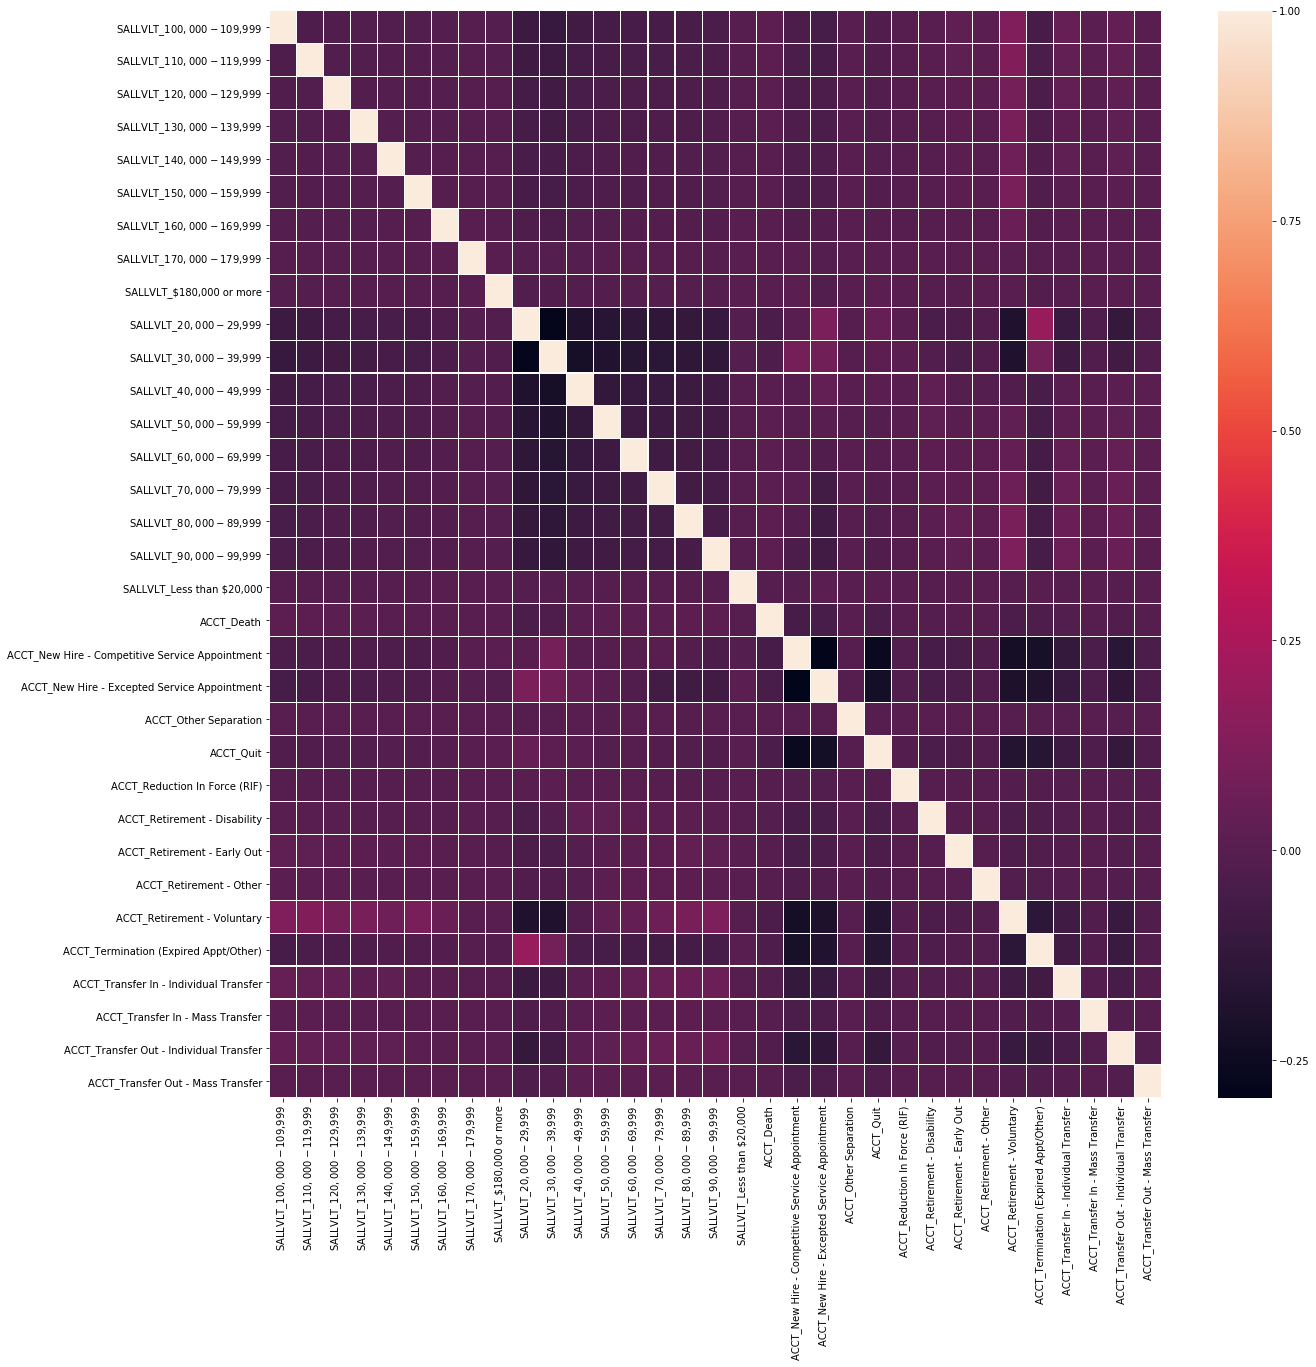

Loading correlation matrix...


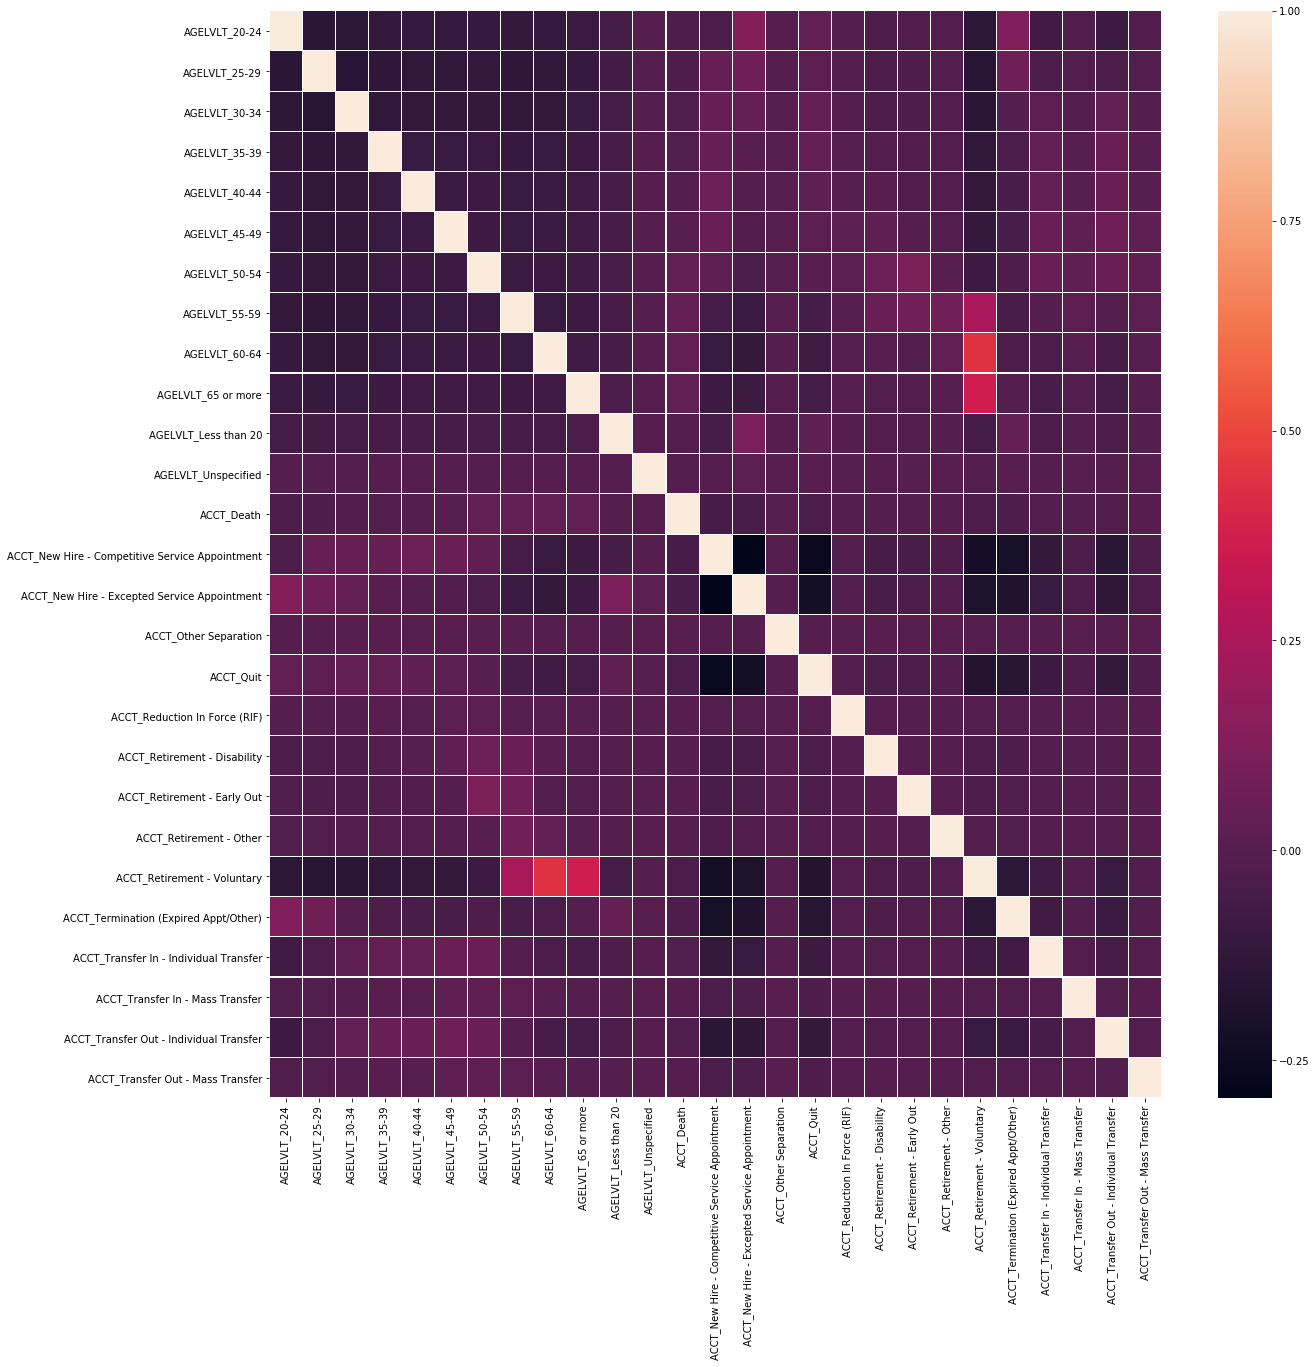

Loading correlation matrix...


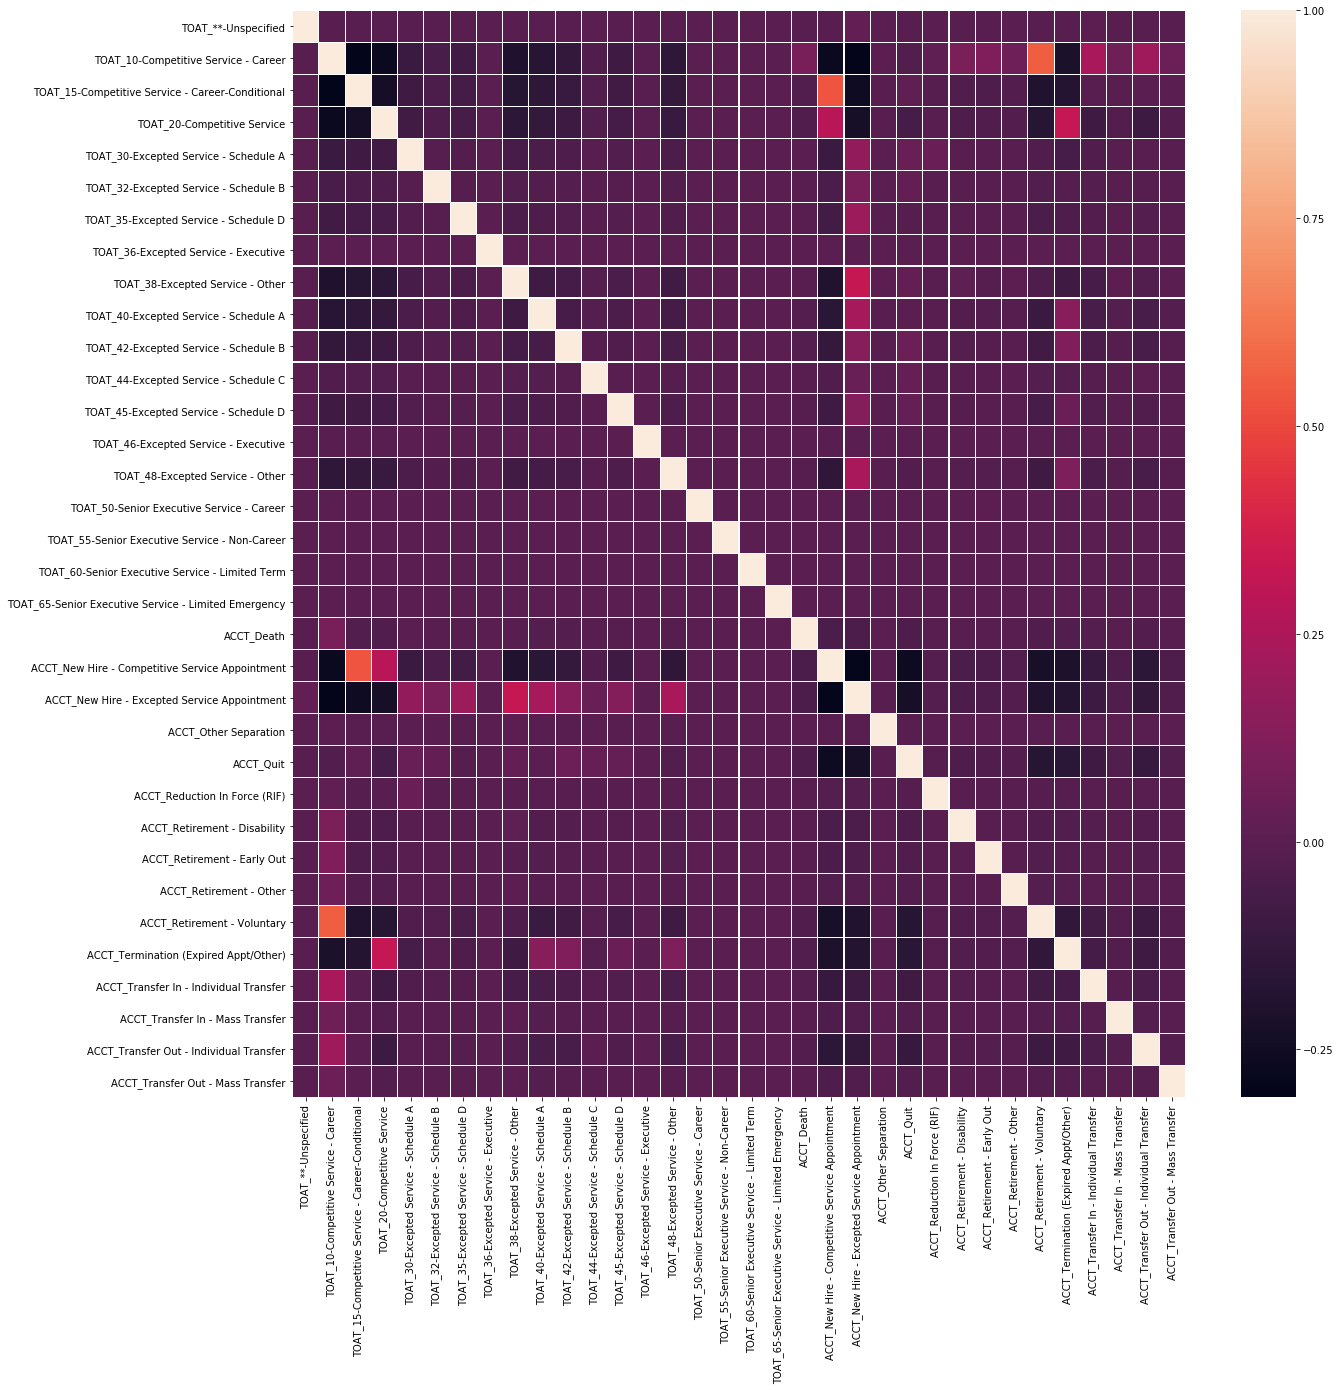

Loading correlation matrix...


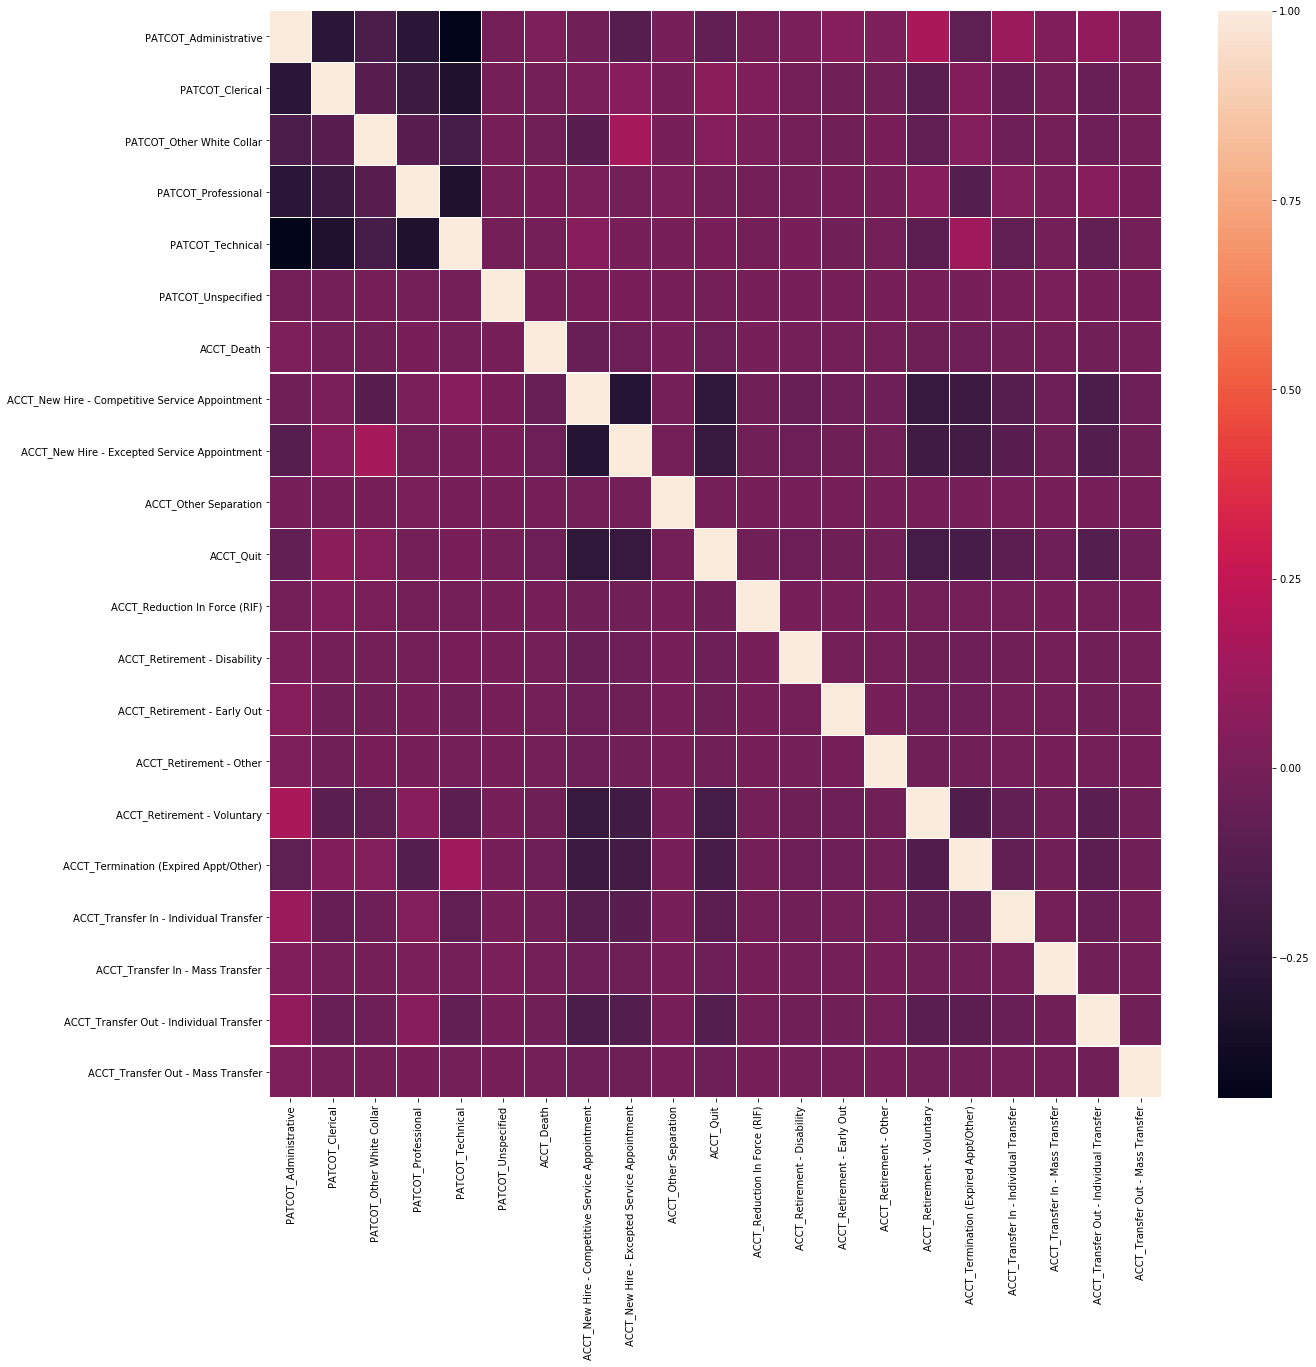

Loading model...
The mean accuracy of the model on the test set is 0.7232284838223685 percent.


In [4]:
opm()